In [1]:
import edlib
import numpy as np
import heapq
import time
from Bio.Seq import Seq
import copy
import matplotlib.pyplot as plt
def rc(seq):
    return str(Seq(seq).reverse_complement())
def calculate_distance(ref, query, ref_st, ref_en, query_st, query_en):
    A = ref[ref_st: ref_en]
    a = query[query_st: query_en]
    # _a = rc(query[query_st: query_en])
    # return min(edlib.align(A, a)['editDistance'], edlib.align(A, _a)['editDistance'])
    return edlib.align(A, a)['editDistance']

def calculate_value(points, ref, query,penalty):  
    try:
        editdistance = 0
        aligned = 0
        preend = 0
        for onetuple in points:
            query_st, query_en, ref_st, ref_en = onetuple[0], onetuple[1], onetuple[2], onetuple[3]
            if(preend > query_st):#检测重叠
                return 0
            preend = query_en
            editdistance += calculate_distance(ref, query, ref_st, ref_en, query_st, query_en)
            aligned += query_en - query_st
        return max(aligned - editdistance - len(points) * penalty,0) #额外的惩罚碎片化的输出
    except:
        return 0

In [2]:
def simulated_annealing(origin,update,scoring,t0,kt=0.97,round=20,printf=False):
    score=scoring(origin)
    data=origin

    final=data
    final_score=score
    while(t0>=1):
        for i in range(round):
            nxt_data=update(data,t0)
            nxt_score=scoring(nxt_data)

            delta=nxt_score-score
            if(np.exp(delta/t0)>np.random.rand()):
                data=nxt_data
                score=nxt_score
                if(printf):print(data,score)
                if(score>final_score):
                    final,final_score=data,score
        data=final
        score=final_score
        t0*=kt
        if(printf):print(t0)
    return final,final_score

In [3]:
class PhaseMatch:
    def __init__(self,l,r,ml):
        self.l=l
        self.r=r
        self.scorelist=ml

def printPhaseMatch(l,topk):
    for i in l:
        for j in range(len(i.scorelist)):
            color=1/topk*j
            if(i.scorelist[j][1]>i.scorelist[j][2]):color=(0,0,1-color)
            else:color=(1-color,0,0)
            plt.plot((i.l,i.r),(i.scorelist[j][1],i.scorelist[j][2]),color=color)
    plt.show()

In [4]:
import tqdm
def DNA_match(reference,sample,seglen,penalty,topk):
    match_list=[]
    for i in range(0,len(sample),seglen):
        ri=min(i+seglen,len(sample))
        scorelist=[]
        for j in range(0,len(reference),seglen):
            rj=min(j+seglen,len(sample))
            scorelist.append((ri-i-edlib.align(reference[j:rj],sample[i:ri])['editDistance'],j,rj))
        scorelist=heapq.nlargest(topk,scorelist)

        for j in range(len(scorelist)):

            origin=[[i,ri,scorelist[j][1],scorelist[j][2]]]
            def update(data,t0):
                dv=max(int(t0),5)
                newdata=copy.deepcopy(data)
                newdata[0][2]+=np.random.randint(-dv,dv)
                newdata[0][2]=np.clip(newdata[0][2],0,len(reference))
                newdata[0][3]+=np.random.randint(-dv,dv)
                newdata[0][3]=np.clip(newdata[0][3],0,len(reference))
                return newdata
            def scoring(data):
                return calculate_value(data,reference,sample,penalty)
            data,score=simulated_annealing(origin,update,scoring,3,0.97,5)
            scorelist[j]=(score,data[0][2],data[0][3])
        
        while len(scorelist)>0 and scorelist[-1][0]<=0:scorelist.pop()
        if(len(scorelist)>0):
            match_list.append((PhaseMatch(i,ri,scorelist),1))

    while True:
        mergel=0
        new_match_list=[]
        with tqdm.tqdm(total=len(match_list)) as pbar:
            while(mergel<len(match_list)):
                if(mergel==len(match_list)-1):
                    new_match_list.append((match_list[mergel][0],0))
                    break
                if match_list[mergel][1]==0 and match_list[mergel+1][1]==0:
                    new_match_list.append((match_list[mergel][0],0))
                    mergel+=1
                    pbar.update(1)
                    continue
                l=match_list[mergel][0].l
                r=match_list[mergel+1][0].r
                lenl=match_list[mergel][0].r-match_list[mergel][0].l
                lenr=match_list[mergel+1][0].r-match_list[mergel+1][0].l
                scorelist=[]
                scorebound=match_list[mergel][0].scorelist[0][0]+match_list[mergel+1][0].scorelist[0][0]
                def merge(refl,refr):
                    origin=[[l,r,refl,refr]]
                    def update(data,t0):
                        dv=max(int(t0),10)
                        newdata=copy.deepcopy(data)
                        newdata[0][2]+=np.random.randint(-dv,dv)
                        newdata[0][2]=np.clip(newdata[0][2],0,len(reference))
                        newdata[0][3]+=np.random.randint(-dv,dv)
                        newdata[0][3]=np.clip(newdata[0][3],0,len(reference))
                        return newdata
                    def scoring(data):
                        return calculate_value(data,reference,sample,penalty)
                    data,score=simulated_annealing(origin,update,scoring,max((r-l)//100,5),0.96,10)
                    if(score>scorebound):
                        def IoU(l1,r1,l2,r2):
                            d1=max(r1-l1,0)
                            d2=max(r2-l2,0)
                            d3=max(min(r1,r2)-max(l1,l2),0)
                            if(d3>(d1+d2-d3)*0.9):return False
                            else:return True
                        flag=True
                        for i in scorelist:
                            if not IoU(i[1],i[2],data[0][2],data[0][3]):
                                flag=False
                                break
                        if flag:
                            scorelist.append((score,data[0][2],data[0][3]))
                    
                for j in match_list[mergel][0].scorelist:
                    merge(j[1],min(j[2]+lenr,len(reference)))
                for j in match_list[mergel+1][0].scorelist:
                    merge(max(j[1]-lenl,0),j[2])
                if(len(scorelist)>0):
                    scorelist=heapq.nlargest(topk,scorelist)
                    new_match_list.append((PhaseMatch(l,r,scorelist),1))
                    pbar.update(2)
                    mergel+=2
                else:
                    new_match_list.append((match_list[mergel][0],0))
                    pbar.update(1)
                    mergel+=1
        if(len(new_match_list)<len(match_list)):
            match_list=new_match_list
            print("segment count: ",len(match_list))
        else:
            break
    return match_list 

100%|██████████| 2848/2848 [19:18<00:00,  2.46it/s]   


segment count:  1424


100%|█████████▉| 1423/1424 [03:58<00:00,  5.97it/s]


segment count:  713


100%|█████████▉| 712/713 [02:23<00:00,  4.96it/s]


segment count:  357


100%|█████████▉| 356/357 [01:34<00:00,  3.75it/s]


segment count:  179


100%|██████████| 179/179 [01:40<00:00,  1.77it/s]


segment count:  90


100%|██████████| 90/90 [02:17<00:00,  1.53s/it]


segment count:  46


 98%|█████████▊| 45/46 [02:54<00:03,  3.87s/it]


segment count:  25


 96%|█████████▌| 24/25 [02:35<00:06,  6.46s/it]


segment count:  17


100%|██████████| 17/17 [02:39<00:00,  9.38s/it]


segment count:  15


 93%|█████████▎| 14/15 [01:44<00:07,  7.46s/it]


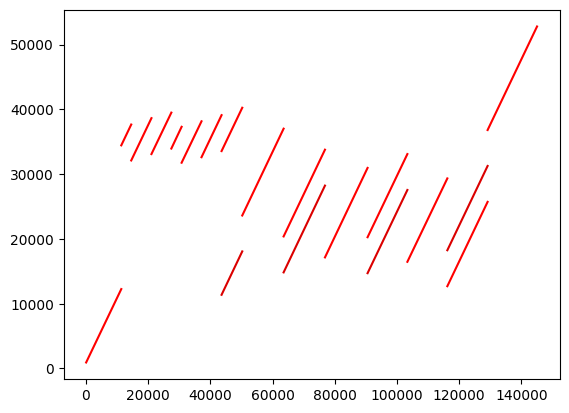

In [5]:
with open("reference.txt",'r') as file:
    reference=file.read()
with open("sample.txt",'r') as file:
    sample=file.read()

topk=7

match_list=DNA_match(reference,sample,50,30,topk)
for i in range(len(match_list)):match_list[i]=match_list[i][0]
printPhaseMatch(match_list,topk)

In [6]:
origin=[[],[]]
for i in match_list:
    origin[0].append([i.l,i.r])
    origin[1].append([i.scorelist[0][1],i.scorelist[0][2]])

def trans(data):
    l=[]
    for i in range(len(data[0])):
        l.append((data[0][i][0],data[0][i][1],data[1][i][0],data[1][i][1]))
    return l
print(origin)
print(trans(origin))
print(calculate_value(trans(origin),reference,sample,30))


[[[50, 11350], [11350, 14550], [14550, 21050], [21050, 27450], [27450, 30750], [30750, 37150], [37150, 43600], [43600, 50250], [50250, 63550], [63550, 76850], [76850, 90550], [90550, 103350], [103350, 116200], [116200, 129150], [129150, 145050]], [[921, 12256], [34447, 37663], [32114, 38648], [33101, 39502], [33953, 37310], [31765, 38162], [32615, 39110], [33563, 40254], [23615, 37022], [20383, 33777], [17145, 30963], [20261, 33102], [16466, 29341], [12699, 25719], [36813, 52802]]]
[(50, 11350, 921, 12256), (11350, 14550, 34447, 37663), (14550, 21050, 32114, 38648), (21050, 27450, 33101, 39502), (27450, 30750, 33953, 37310), (30750, 37150, 31765, 38162), (37150, 43600, 32615, 39110), (43600, 50250, 33563, 40254), (50250, 63550, 23615, 37022), (63550, 76850, 20383, 33777), (76850, 90550, 17145, 30963), (90550, 103350, 20261, 33102), (103350, 116200, 16466, 29341), (116200, 129150, 12699, 25719), (129150, 145050, 36813, 52802)]
139292


In [ ]:
import numpy as np
def trans(data):
    l=[]
    for i in range(len(data[0])):
        l.append((data[0][i][0],data[0][i][1],data[1][i][0],data[1][i][1]))
    return l

def scoring(data):
    return calculate_value(trans(data),reference,sample,30)

for round in range(100):
    l=round%(len(origin[0])-1)
    origin1=[
        [[origin[0][l][0],origin[0][l][1]],[origin[0][l+1][0],origin[0][l+1][1]]],
        [[origin[1][l][0],origin[1][l][1]],[origin[1][l+1][0],origin[1][l+1][1]]]
    ]
    saml=0 if l==0 else origin[0][l-1][1]
    samr=len(sample) if l+1==len(origin[0])-1 else origin[0][l+2][0]

    def update1(data,t0):
        newdata=copy.deepcopy(data)
        dv=max(int(t0),1)
        l=[]
        for i in range(len(data[0])):
            l.append(np.clip(data[0][i][0]+np.random.randint(-dv,dv),saml,samr))
            l.append(np.clip(data[0][i][1]+np.random.randint(-dv,dv),saml,samr))
        l.sort()
        for i in range(len(data[0])):
            newdata[0][i]=[l[i*2],l[i*2+1]]

        for i in range(len(data[0])):
            def update1(data,t0):
                dv=max(int(t0),10)
                newdata:list=copy.deepcopy(data)
                newdata[0]=newdata[0]+np.random.randint(-dv,dv)
                newdata[0]=np.clip(newdata[0],0,len(reference))
                newdata[1]=newdata[1]+np.random.randint(-dv,dv)
                newdata[1]=np.clip(newdata[1],0,len(reference))
                newdata.sort()
                return newdata
            def scoring1(data1):
                return calculate_value([(newdata[0][i][0],newdata[0][i][1],data1[0],data1[1])],reference,sample,30)
            
            newdata[1][i],score=simulated_annealing(data[1][i],update1,scoring1,t0,0.96,10)
        return newdata
    
    def trans1(data):
        l=[]
        for i in range(len(data[0])):
            l.append((data[0][i][0],data[0][i][1],data[1][i][0],data[1][i][1]))
        return l

    def scoring1(data):
        return calculate_value(trans(data),reference,sample,30)
    
    data1,score=simulated_annealing(origin1,update1,scoring1,25,0.96,10)
    origin[0][l],origin[0][l+1]=data1[0][0],data1[0][1]
    origin[1][l],origin[1][l+1]=data1[1][0],data1[1][1]
    print(round,scoring(origin),trans(origin),sep=" ")


print(trans(origin))
print(scoring(origin))    

0 139337 [(0, 11391, 870, 12297), (11391, 14550, 34487, 37663), (14550, 21050, 32114, 38648), (21050, 27450, 33101, 39502), (27450, 30750, 33953, 37310), (30750, 37150, 31765, 38162), (37150, 43600, 32615, 39110), (43600, 50250, 33563, 40254), (50250, 63550, 23615, 37022), (63550, 76850, 20383, 33777), (76850, 90550, 17145, 30963), (90550, 103350, 20261, 33102), (103350, 116200, 16466, 29341), (116200, 129150, 12699, 25719), (129150, 145050, 36813, 52802)]
1 139337 [(0, 11391, 870, 12297), (11391, 14550, 34487, 37663), (14550, 21050, 32114, 38648), (21050, 27450, 33101, 39502), (27450, 30750, 33953, 37310), (30750, 37150, 31765, 38162), (37150, 43600, 32615, 39110), (43600, 50250, 33563, 40254), (50250, 63550, 23615, 37022), (63550, 76850, 20383, 33777), (76850, 90550, 17145, 30963), (90550, 103350, 20261, 33102), (103350, 116200, 16466, 29341), (116200, 129150, 12699, 25719), (129150, 145050, 36813, 52802)]
2 139337 [(0, 11391, 870, 12297), (11391, 14550, 34487, 37663), (14550, 21050,